In [9]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [10]:
import gym
import matplotlib.pyplot as plt
import numpy as np

In [11]:
import datetime as dt
import time

In [12]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [14]:
seed= 42
set_seed(seed)

# For Loop Method

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
        
        return x3   

In [16]:
class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma= 0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []
        
        self.reward_memory_saved = []
        self.action_memory_saved = []
        
        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)
        
    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state))
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)
        
        return action.item()
    
    def store_rewards(self, reward):
        self.reward_memory.append(reward)
               
    def learn(self):
        self.policy.optimizer.zero_grad()
        
        # G_t = R_t+1 + gamma * R_t+2 + gamma**2 * R_t+3
        # G_t = sum from k=0 to k=T {gamma**k * R_t+k+1}
        
        # too many for loops
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum=0
            discount=1
            for k in range(t, len(self.action_memory)):
                G_sum += self.reward_memory[k] *discount
                discount *= self.gamma
            G[t]=G_sum
        
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        loss=0
        for g, logprob in zip(G, self.action_memory):
            loss+= -g * logprob
        loss.backward()
        self.policy.optimizer.step()
        
        self.reward_memory_saved.append(self.reward_memory)
        self.action_memory_saved.append(self.action_memory)
        
        self.reward_memory = []
        self.action_memory = []

In [17]:
env = gym.make('LunarLander-v2')
env.seed(seed)
n_games = 3001
agent = PolicyGradientAgent(gamma=0.99, lr=0.0005, input_dims=[8],
                            n_actions=4)
episode_time=[]
scores = []
for i in range(n_games):
    toc= time.time()
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_rewards(reward)
        observation = observation_
    agent.learn()
    scores.append(score)
    tic=time.time()
    episode_time.append(tic-toc)
    intvl=250
    if i % intvl == 0:
        avg_score = np.mean(scores[-intvl:])
        avg_time = np.mean(episode_time[-intvl:])
        print('Episode ', i, 'Score %.2f' % score, 'Average score %.2f' % avg_score, 'Average episode time %.2f' % avg_time, '(sec)')
env.close()

C:\Users\M323742\Anaconda3\envs\DeepRL\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Episode  0 Score -254.51 Average score -254.51 Average episode time 0.09 (sec)
Episode  250 Score -24.39 Average score -156.90 Average episode time 0.09 (sec)
Episode  500 Score -117.73 Average score -137.29 Average episode time 0.11 (sec)
Episode  750 Score -98.48 Average score -115.07 Average episode time 0.11 (sec)
Episode  1000 Score -96.45 Average score -75.60 Average episode time 0.16 (sec)
Episode  1250 Score 23.85 Average score -26.97 Average episode time 0.25 (sec)
Episode  1500 Score 126.07 Average score 17.17 Average episode time 0.94 (sec)
Episode  1750 Score -34.05 Average score 53.25 Average episode time 1.03 (sec)
Episode  2000 Score 140.32 Average score 99.59 Average episode time 1.62 (sec)
Episode  2250 Score -219.67 Average score 60.28 Average episode time 0.82 (sec)
Episode  2500 Score 165.42 Average score 92.77 Average episode time 0.59 (sec)
Episode  2750 Score -71.41 Average score 65.49 Average episode time 0.81 (sec)
Episode  3000 Score 42.46 Average score 103.42

In [18]:
print('Time to complete %.2f', np.array(episode_time).sum()/60, '(minutes)')

Time to complete %.2f 30.123022456963856 (minutes)


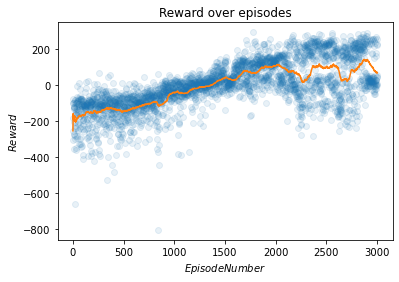

In [19]:
x = [i+1 for i in range(len(scores))]
running_avg = np.zeros(len(scores))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])

plt.plot(x, scores, 'o', alpha=0.1)
plt.plot(x, running_avg)
plt.title('Reward over episodes')
plt.ylabel(r'$Reward$')
plt.xlabel(r'$Episode Number$')
plt.show()

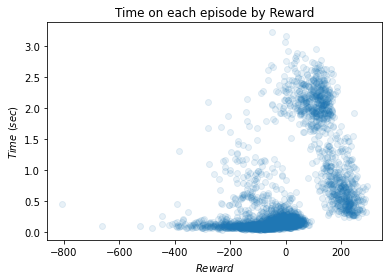

In [20]:
x = scores
y=episode_time
plt.plot(x, y, 'o', alpha=0.1)

plt.title('Time on each episode by Reward')
plt.ylabel(r'$Time \ (sec)$')
plt.xlabel(r'$Reward$')
plt.show()

# Fin

In [21]:
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Friday September 24, 2021 at 15:10
